In [1]:
%matplotlib inline
import datetime as dt
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mtpltim
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from geopy.distance import vincenty
from geopy.distance import great_circle

from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.neighbors.kde import KernelDensity #estymatory
from sklearn.neighbors import LocalOutlierFactor #gestosciowe outliersy

#set figures size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8

np.random.seed(12532)
time_now = dt.datetime.now()

#data load
train = pd.read_csv('../Dane/train.csv')
#show sample rows to learn data attributes
#print("Sample rows")
test = pd.read_csv('../Dane/test.csv')



In [2]:
##change string date to datetime format

train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
# make date attribute for train set
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')

test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
#make date attribute for test set
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

In [3]:
## get longest trip
print("longest trip in hours before outliers removal ", train['trip_duration'].max()//3600)
print("Train length before 3 sigmas ",len(train))

# delete trips longer than 3 standard deviations and shorter than 3 std deviations, those are probably mistakes
#longest ride was from nyc to loa angeles, about 42 hours acording to google maps
#but this is human unpredictability
# we will deal with it later

# 3 sigmas
trip_mean = np.mean(train['trip_duration'])
trip_std = np.std(train["trip_duration"])
train = train[train["trip_duration"] >= trip_mean-3*trip_std]
train = train[train["trip_duration"] <= trip_mean+3*trip_std]


longest trip in hours before outliers removal  618
Train length before 3 sigmas  1458643


In [4]:
#usuwa więcej niż 3 sigma
#hampel Filter 
k = int(len(train)/5) #window size
t0 = 3
L = 1.4826
#rolling median to poruszajaca się mediana, liczymy ja dla zadanego okna o długosci k,
#mediane dla punktu n wylicza się z k ostatnich wartości https://pl.wikipedia.org/wiki/%C5%9Arednia_ruchoma
rolling_median=train["trip_duration"].rolling(k).median()
difference=np.abs(rolling_median-train["trip_duration"])
median_abs_deviation=difference.rolling(k).median()
threshold = t0 *L * median_abs_deviation
outlier_idx = difference > threshold

print("Train length before hampel ",len(train))
print("Outliers count ",len(train[outlier_idx==True]["trip_duration"]))
#wyrzucenie rekordów dla którcyh flaga outlier_idx == True
train = train[outlier_idx == False]

print("Train length after hampel ",len(train))
print("longest trip in hours after outliers removal ", train['trip_duration'].max()//3600)

Train length before hampel  1456563
Outliers count  46766
Train length after hampel  1409797
longest trip in hours after outliers removal  3


In [5]:
#better results when coords constrained to nyc borders
lg_border = (-74.15, -73.7)
lt_border = (40.6, 40.9)
train = train[train["pickup_longitude"] >= lg_border[0]]
train = train[train["pickup_longitude"] <= lg_border[1]]
train = train[train["pickup_latitude"] >= lt_border[0]]
train = train[train["pickup_latitude"] <= lt_border[1]]

Trip duration median  642.0
Trip duration mean  772.071561521


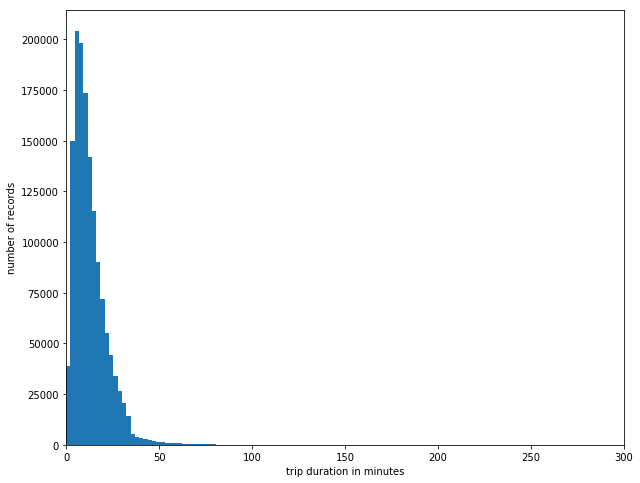

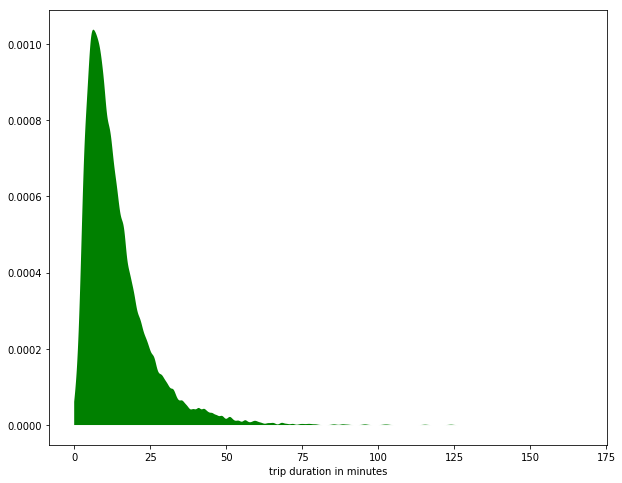

In [6]:
#print trip duration median and mean
print("Trip duration median ", train["trip_duration"].median())
print("Trip duration mean ",train["trip_duration"].mean())


#plot trip duration distribution in normal scale
plt.rcParams["figure.figsize"] = fig_size
plt.hist(train['trip_duration'].values/60, bins=100)
plt.xlabel('trip duration in minutes')
plt.ylabel('number of records')
plt.xlim(0,300)
plt.show()

#kernel density esitmation <-estymatory jądrowe
X_plot = train['trip_duration'].index.values[0:10000].reshape(-1, 1)
reshape_train_outlier = train["trip_duration"].values[0:10000].reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=40).fit(reshape_train_outlier)
logprob = kde.score_samples(X_plot)

plt.fill_between(X_plot[:,0]/60, np.exp(logprob), facecolor='green', interpolate=True)
plt.xlabel('trip duration in minutes')
plt.savefig('../Wyniki/Wykresy/duration_records.png')
plt.show()

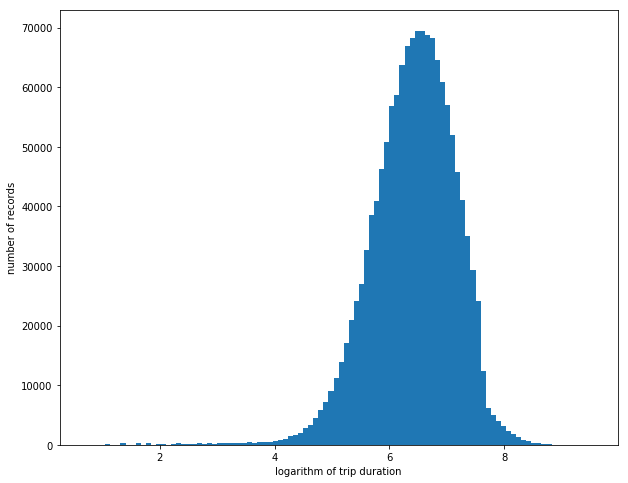

In [7]:
#because evaluation metric is RMSLE, we need to get logartihm transform to bettersee distribution,
train['log_of_duration'] = np.log(train['trip_duration'].values + 1)

plt.rcParams["figure.figsize"] = fig_size
#plot trip duration distribution in logarithm scale
plt.hist(train['log_of_duration'].values, bins=100)
plt.xlabel('logarithm of trip duration')
plt.ylabel('number of records')
plt.show()

#kernel density esitmation <-estymatory jądrowe
X_plot = np.linspace(0, 10, 1000, endpoint=False).reshape(-1, 1)
reshape_train_outlier = train['log_of_duration'].values[0:1000].reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(reshape_train_outlier)
logprob = kde.score_samples(X_plot)

plt.fill_between(X_plot[:,0], np.exp(logprob), facecolor='green', interpolate=True)
plt.xlabel('trip duration')
plt.savefig('../Wyniki/Wykresy/duration_records_log.png')
plt.show()

In [8]:
#record numbers from train set corespond to record number from test set,
# ratio of records numbers of this two sets seems constant this means that records from train set are random
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train dataset')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test dataset')
plt.title('Number of trips in train and test')
plt.ylabel('Number of records')
plt.savefig('../Wyniki/Wykresy/train_test_ratio.png')
plt.show()


In [9]:
##check the simplest relationships, there are only 2 vendors, 2 flags and 10 passenger options
#no difference grouping by vendor
by_vendor = train.groupby('vendor_id')['trip_duration'].mean()
print("trip duration by :",by_vendor)

#significant difference grouping by store and forward flag, about 30% longer trips if flag is YESs
by_flag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()
print("trip duration by :",by_flag)

# 0 passengers should mean taxi delivery - difference, 7 passengers- big difference, 8 passengers - big difference
#9 passenegers - visible difference
#by_passengers = train.groupby('passenger_count')['trip_duration'].mean()
#print("trip duration by :",by_passengers)

trip duration by : vendor_id
1    768.590887
2    775.111547
Name: trip_duration, dtype: float64
trip duration by : store_and_fwd_flag
0    771.279551
1    921.822903
Name: trip_duration, dtype: float64


In [10]:
# number of record per passenger count
records_number_by_passengers = train.groupby('passenger_count').size()
print("number of records in train set :",records_number_by_passengers)

#the same for test set
records_number_by_passengers = test.groupby('passenger_count').size()
print("number of records in testset :",records_number_by_passengers)

#we can see that 7,8,9 passengers are outliners
train = train[train["passenger_count"] < 7]

number of records in train set : passenger_count
0         56
1    1000545
2     201988
3      57664
4      27175
5      75203
6      46601
7          1
8          1
9          1
dtype: int64
number of records in testset : passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64


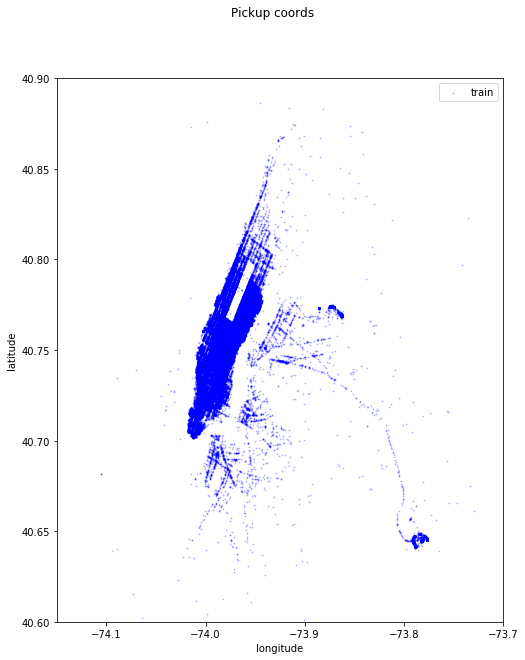

In [11]:
#40.957434, -74.216083 - top left
#40.446149, -73.651738 - bottom right

N = 100000 # number of sample rows in plots

## display pickup cordinantes on map to see where is the highest density of pickups

#set figures size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.2)
plt.suptitle('Pickup coords')
plt.legend(loc=0)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(lt_border)
plt.xlim(lg_border)
plt.savefig('../Wyniki/Wykresy/pickup_coords.png')
plt.show()

In [12]:
#użycie metody gęstosciowej usuwania el. odosobnionych w odniesieniu do punktów zbiórek pasazerow
clf = LocalOutlierFactor(n_neighbors=50,algorithm='auto',leaf_size=60,metric='manhattan',n_jobs=2)
lof_set = train[['pickup_longitude','pickup_latitude']]
y_pred = clf.fit_predict(lof_set)   # znalezienie outliersow, w y_pred sa przechowywane 1 dla elementow bedacych inlier
                                    # i -1 dla elementow bedacych outliersami
lof_in = lof_set[y_pred > 0]
lof_out = lof_set[y_pred < 0]

#druga iteracja znajdowania po gestosci, problem z tym algorytmem jest taki, ze zawsze 10% jest outliersami
clf = LocalOutlierFactor(n_neighbors=40,algorithm='auto',leaf_size=50,metric='manhattan',n_jobs=2)
lof_set2 = lof_out
y_pred2 = clf.fit_predict(lof_set2)   # znalezienie outliersow, w y_pred sa przechowywane 1 dla elementow bedacych inlier
                                    # i -1 dla elementow bedacych outliersami
lof_in2 = lof_set2[y_pred2 > 0]
lof_out2 = lof_set2[y_pred2 < 0]
print("liczba outliersow z gestosci: ", len(lof_out2))

liczba outliersow z gestosci:  14093


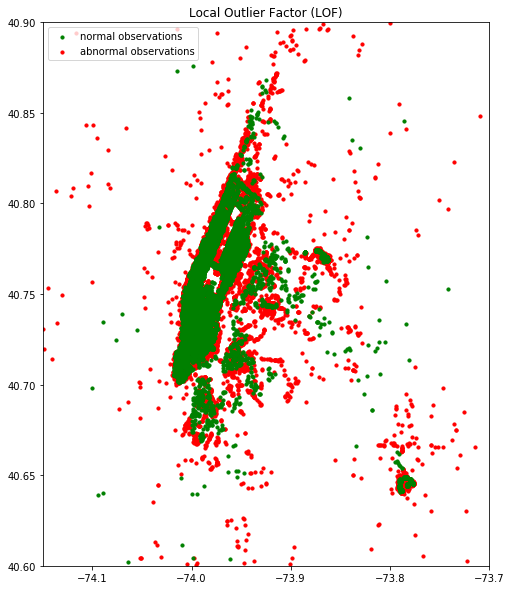

In [13]:
clf_N = 14000
plt.title("Local Outlier Factor (LOF)")
#plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
b = plt.scatter(lof_out2.values[:clf_N, 0], lof_out2.values[:clf_N, 1], c='red',
                edgecolor='red', s=10)
a = plt.scatter(lof_in2.values[:clf_N, 0], lof_in2.values[:clf_N, 1], c='green',
                edgecolor='green', s=10)
plt.axis('tight')
plt.xlim(lg_border)
plt.ylim(lt_border)
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.savefig('../Wyniki/Wykresy/lof.png')
plt.show()

In [14]:
print("train elements count before drop: ",len(train))
outliers_indexes = lof_out2.index
train = train[~train.index.isin(outliers_indexes)]
print("train elements count after drop: ",len(train))

train elements count before drop:  1409232
train elements count after drop:  1395139


In [15]:
def MahalanobisDist(x, y):
    covariance_xy = np.cov(x,y, rowvar=0)
    inv_covariance_xy = np.linalg.inv(covariance_xy)
    xy_mean = np.mean(x),np.mean(y)
    x_diff = np.array([x_i - xy_mean[0] for x_i in x])
    y_diff = np.array([y_i - xy_mean[1] for y_i in y])
    diff_xy = np.transpose([x_diff, y_diff])
    
    md = []
    for i in range(len(diff_xy)):
        md.append(np.sqrt(np.dot(np.dot(np.transpose(diff_xy[i]),inv_covariance_xy),diff_xy[i])))
    return md

def MD_removeOutliers(x, y):
    MD = MahalanobisDist(x, y)
    threshold = np.mean(MD) * 5 # adjust 1.5 accordingly 
    outliers = pd.DataFrame(index=train.index, columns=['isOutlier'])
    outliers['isOutlier'] = MD > threshold
    return outliers


inliers count:  1374687
outliers count:  20452


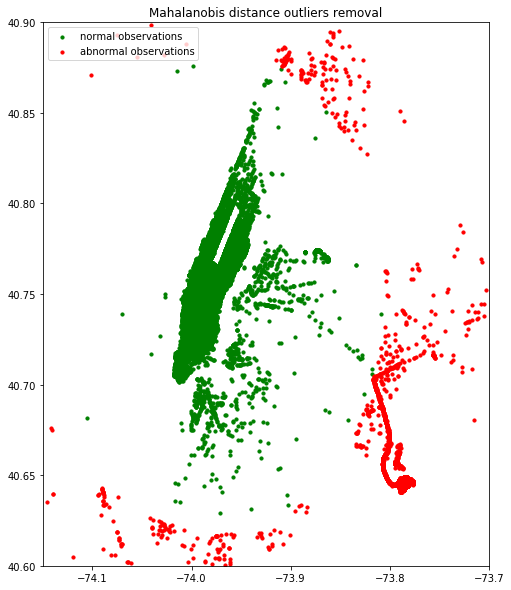

In [16]:
md_set = train[['pickup_longitude','pickup_latitude']]
out = MD_removeOutliers(md_set.values[:,0],md_set.values[:,1]);

test_in = md_set[out['isOutlier'] == False]
test_out = md_set[out['isOutlier'] == True]
print("inliers count: ",len(test_in))
print("outliers count: ",len(test_out))
clf_N = 30000
xx, yy = np.meshgrid(np.linspace(lg_border[0], lg_border[1], 1000), np.linspace(lt_border[0], lt_border[1], 1000))

plt.title("Mahalanobis distance outliers removal")
a = plt.scatter(test_in.values[:clf_N, 0], test_in.values[:clf_N, 1], c='green',
                edgecolor='green', s=10)
b = plt.scatter(test_out.values[:clf_N, 0], test_out.values[:clf_N, 1], c='red',
                edgecolor='red', s=10)
plt.axis('tight')
plt.xlim(lg_border)
plt.ylim(lt_border)
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.savefig('../Wyniki/Wykresy/mahalanobis.png')
plt.show()

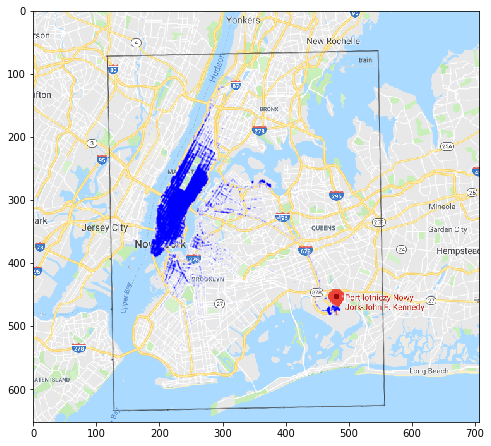

In [17]:
#nyc map with pickups coords
# the majority of pickups takes place in manhattan,
image =  mtpltim.imread('../Dane/Mapa_pickups.png')
plt.imshow(image)
plt.show()

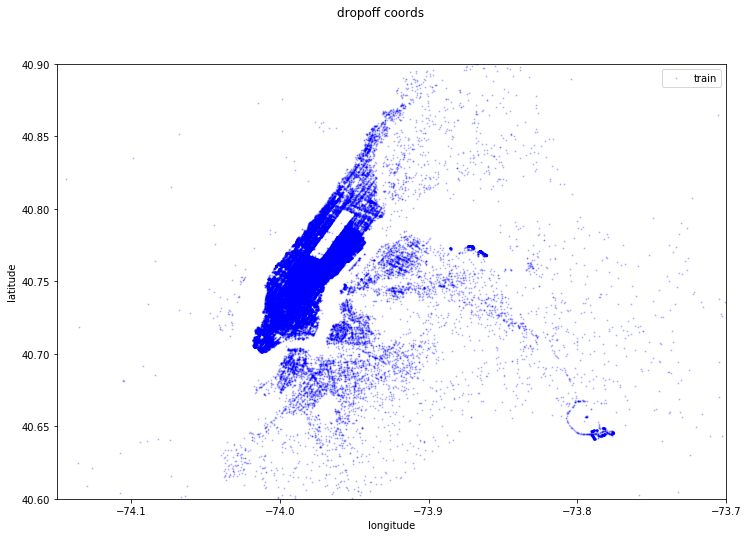

In [18]:

#set figures size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

#dropoffs often take place outside manhattan, but this won't be consider in our model
plt.scatter(train['dropoff_longitude'].values[:N], train['dropoff_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.2)
plt.suptitle('dropoff coords')
plt.legend(loc=0)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(lt_border)
plt.xlim(lg_border)
plt.show()

In [19]:
#we tried to use vincenty function but it takes to long so this is rewriten vbersion of harvesine to work with arrays
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
train.loc[:, 'distance'] = haversine(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'avg_speed'] = 1000 * train['distance'] / train['trip_duration']

test.loc[:, 'distance'] = haversine(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [20]:
#direction could be good attribute too, because in some direction trip should be faster and in other slower
def direction(lt1, lg1, lt2, lg2):
    lg_delta = np.radians(lg2 - lg1)
    lt1, lg1, lt2, lg2 = map(np.radians, (lt1, lg1, lt2, lg2))
    y = np.sin(lg_delta) * np.cos(lt2)
    x = np.cos(lt1) * np.sin(lt2) - np.sin(lt1) * np.cos(lt2) * np.cos(lg_delta)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'direction'] = direction(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = direction(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

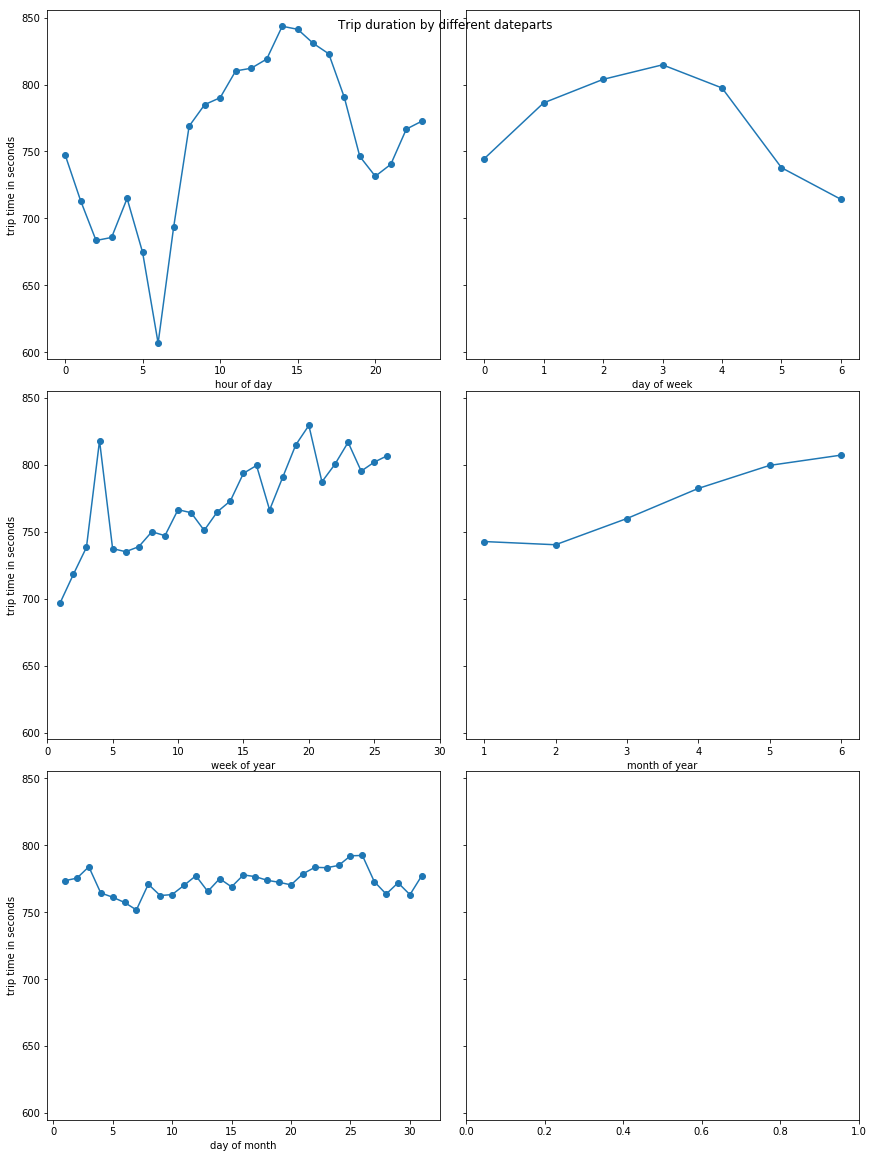

In [21]:
#data decomposition to see how hour, day of week and so on affect on trip duration and traffic
train['hour'] = train['pickup_datetime'].dt.hour
train['day'] = train['pickup_datetime'].dt.dayofweek
train['week'] = train['pickup_datetime'].dt.week
train['month'] = train['pickup_datetime'].dt.month
train['day_of_month'] = train['pickup_datetime'].dt.day

#because python plots one value at the end of year
train = train[train['week'] <= 26]

test['hour'] = test['pickup_datetime'].dt.hour
test['day'] = test['pickup_datetime'].dt.dayofweek
test['week'] = test['pickup_datetime'].dt.week
test['month'] = test['pickup_datetime'].dt.month
test['day_of_month'] = test['pickup_datetime'].dt.day

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size
fig, ax = plt.subplots(nrows=3,ncols=2, sharey=True)
#thanks to that subplots doesn't overlap
fig.tight_layout()

ax[0,0].plot(train.groupby('hour').mean()['trip_duration'], 'o-')

ax[0,1].plot(train.groupby('day').mean()['trip_duration'], 'o-')

ax[1,0].plot(train.groupby('week').mean()['trip_duration'], 'o-')
ax[1,0].set_xlim([0,30])

ax[1,1].plot(train.groupby('month').mean()['trip_duration'], 'o-')

ax[2,0].plot(train.groupby('day_of_month').mean()['trip_duration'], 'o-')

ax[0,0].set_xlabel('hour of day')
ax[0,1].set_xlabel('day of week')
ax[1,0].set_xlabel('week of year')
ax[1,1].set_xlabel('month of year')
ax[2,0].set_xlabel('day of month')

ax[0,0].set_ylabel('trip time in seconds')
ax[1,0].set_ylabel('trip time in seconds')
ax[2,0].set_ylabel('trip time in seconds')
fig.suptitle('Trip duration by different dateparts')
plt.savefig('../Wyniki/Wykresy/duration_dateparts.png')
plt.show()
#trip duration in reference to different date parts doesn't give us clear information because, we know nothing what couses
#trip duration long or short
#next step its to see trip distance by different dateparts


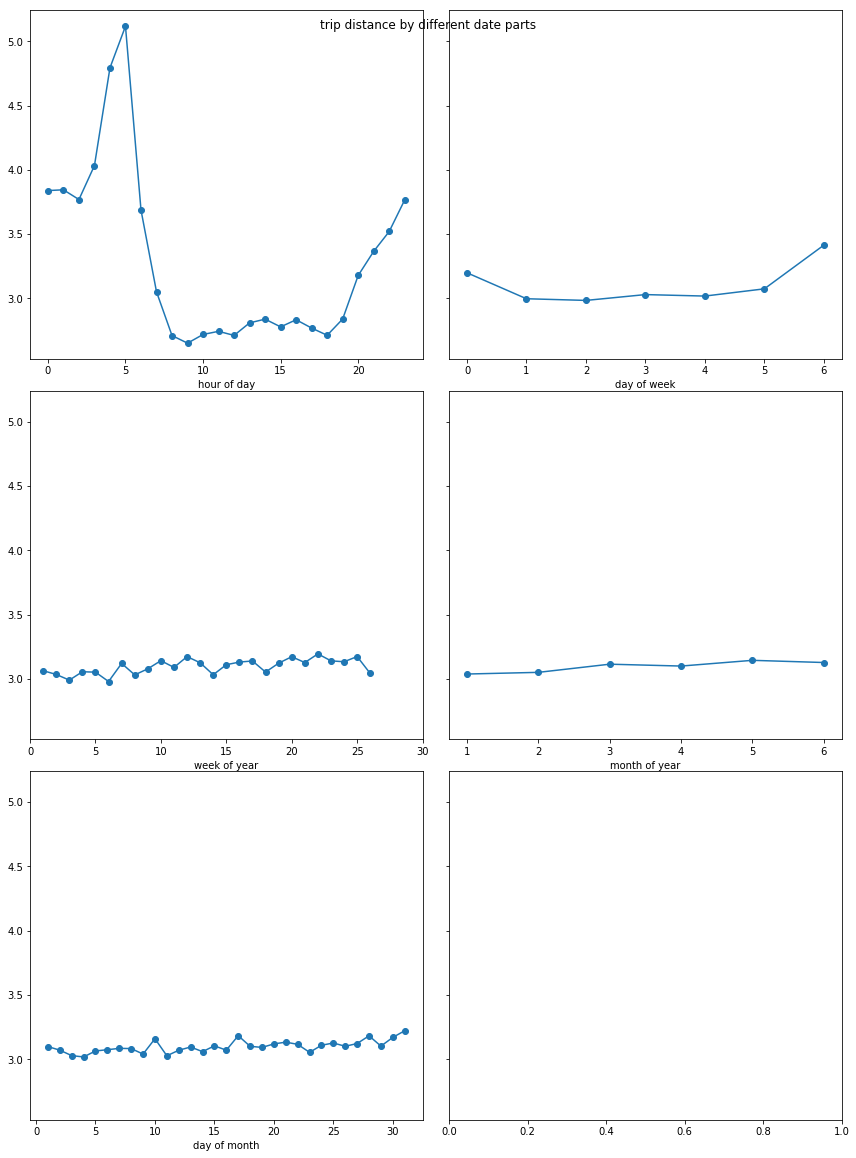

In [22]:

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size
# the best option is to make plot of avg_speed to date parts
fig, ax = plt.subplots(nrows=3,ncols=2, sharey=True)
#thanks to that subplots doesn't overlap
fig.tight_layout()


ax[0,0].plot(train.groupby('hour').mean()['distance'], 'o-')

ax[0,1].plot(train.groupby('day').mean()['distance'], 'o-')

ax[1,0].plot(train.groupby('week').mean()['distance'], 'o-')
ax[1,0].set_xlim([0,30])

ax[1,1].plot(train.groupby('month').mean()['distance'], 'o-')

ax[2,0].plot(train.groupby('day_of_month').mean()['distance'], 'o-')

ax[0,0].set_xlabel('hour of day')
ax[0,1].set_xlabel('day of week')
ax[1,0].set_xlabel('week of year')
ax[1,1].set_xlabel('month of year')
ax[2,0].set_xlabel('day of month')

fig.suptitle('trip distance by different date parts')
plt.savefig('../Wyniki/Wykresy/distance_records.png')
plt.show()
#we clearly see that most important is hour of day, day of week have some valuable information because on monday and sunday 
#trips are longer
#comparing trip duration and trip distance by different date parts, we can see that long morning trips(around 5) 
#are much faster than short trips after 6, we wil make distance dependent on trip duration, this will give us trip avg speed,
#And give us information about traffic
#TODO: opisać zależność dysnatsu od godziny, dni, tygodni itp.


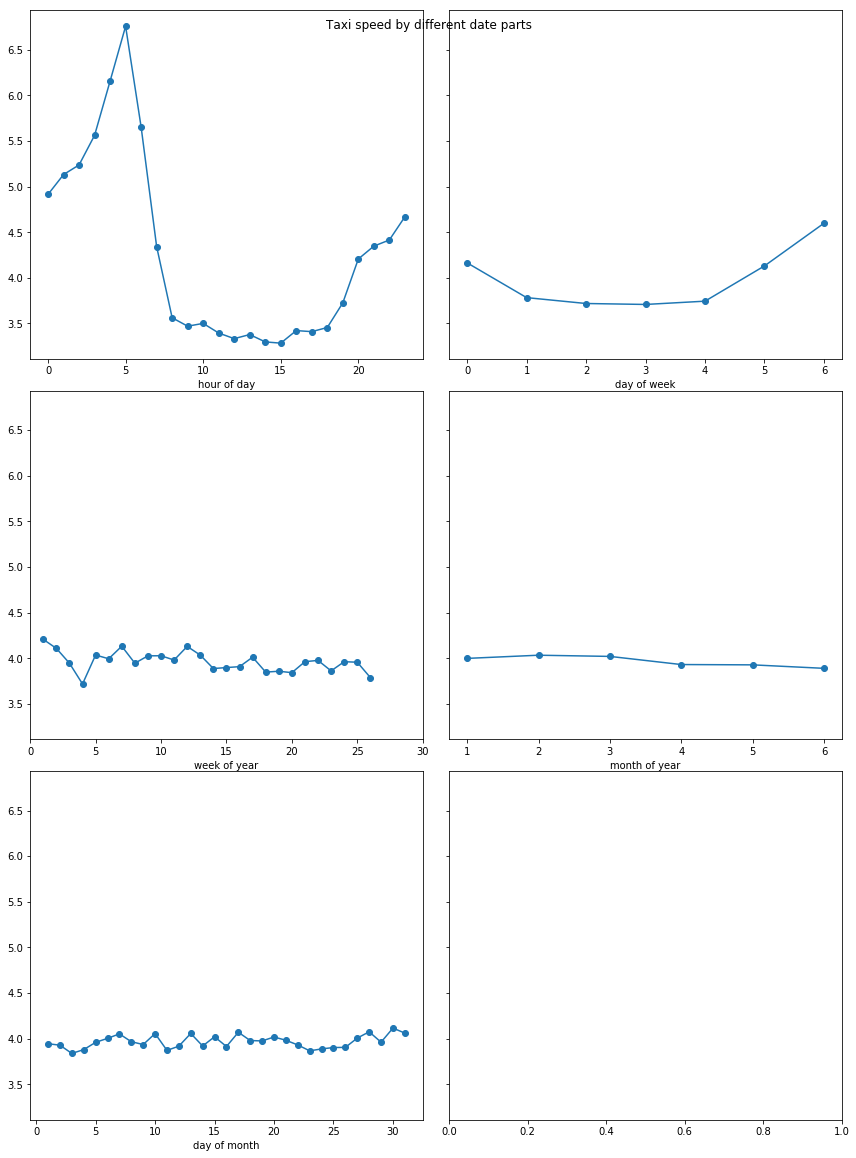

In [23]:
# the best option is to make plot of avg_speed to date parts

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots(nrows=3,ncols=2, sharey=True)
#thanks to that subplots doesn't overlap
fig.tight_layout()

ax[0,0].plot(train.groupby('hour').mean()['avg_speed'], 'o-')

ax[0,1].plot(train.groupby('day').mean()['avg_speed'], 'o-')

ax[1,0].plot(train.groupby('week').mean()['avg_speed'], 'o-')
ax[1,0].set_xlim([0,30])

ax[1,1].plot(train.groupby('month').mean()['avg_speed'], 'o-')

ax[2,0].plot(train.groupby('day_of_month').mean()['avg_speed'], 'o-')

ax[0,0].set_xlabel('hour of day')
ax[0,1].set_xlabel('day of week')
ax[1,0].set_xlabel('week of year')
ax[1,1].set_xlabel('month of year')
ax[2,0].set_xlabel('day of month')

fig.suptitle('Taxi speed by different date parts')
plt.savefig('../Wyniki/Wykresy/speed_dateparts.png')
plt.show()

In [24]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots(nrows=3,ncols=2, sharey=True)
#thanks to that subplots doesn't overlap
fig.tight_layout()

ax[0,0].plot(train.groupby('hour').size(), 'o-')

ax[0,1].plot(train.groupby('day').size(), 'o-')

ax[1,0].plot(train.groupby('week').size(), 'o-')
ax[1,0].set_xlim([0,30])

ax[1,1].plot(train.groupby('month').size(), 'o-')

ax[2,0].plot(train.groupby('day_of_month').size(), 'o-')

ax[0,0].set_xlabel('hour of day')
ax[0,1].set_xlabel('day of week')
ax[1,0].set_xlabel('week of year')
ax[1,1].set_xlabel('month of year')
ax[2,0].set_xlabel('day of month')

fig.suptitle('Number of Records by different date parts')
plt.show()

c:\users\izanagi\appdata\local\programs\python\python36\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


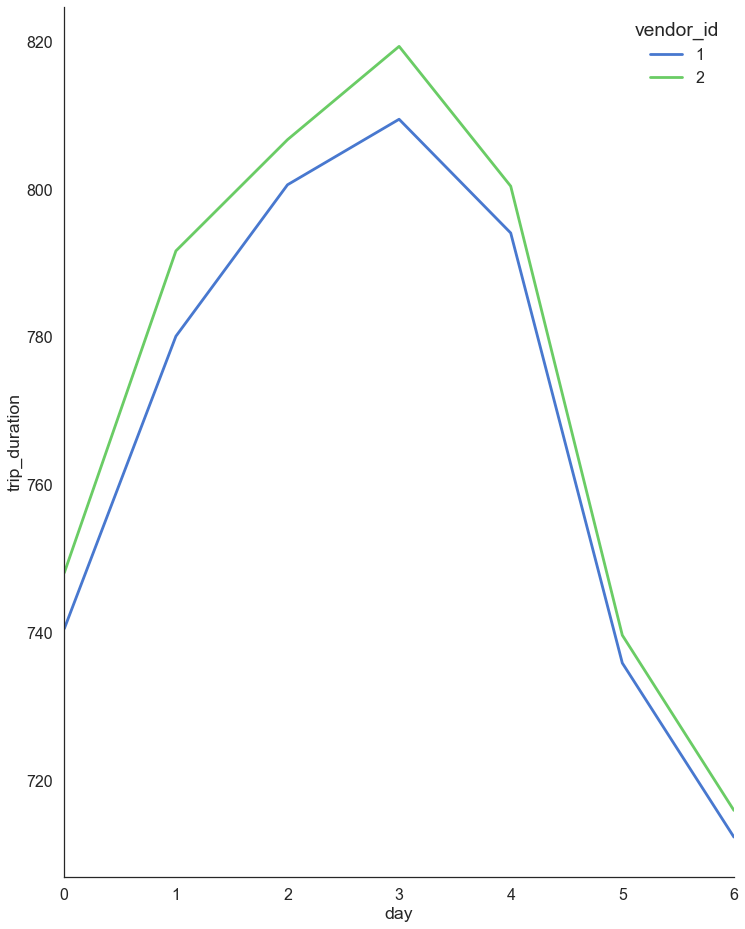

In [25]:
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

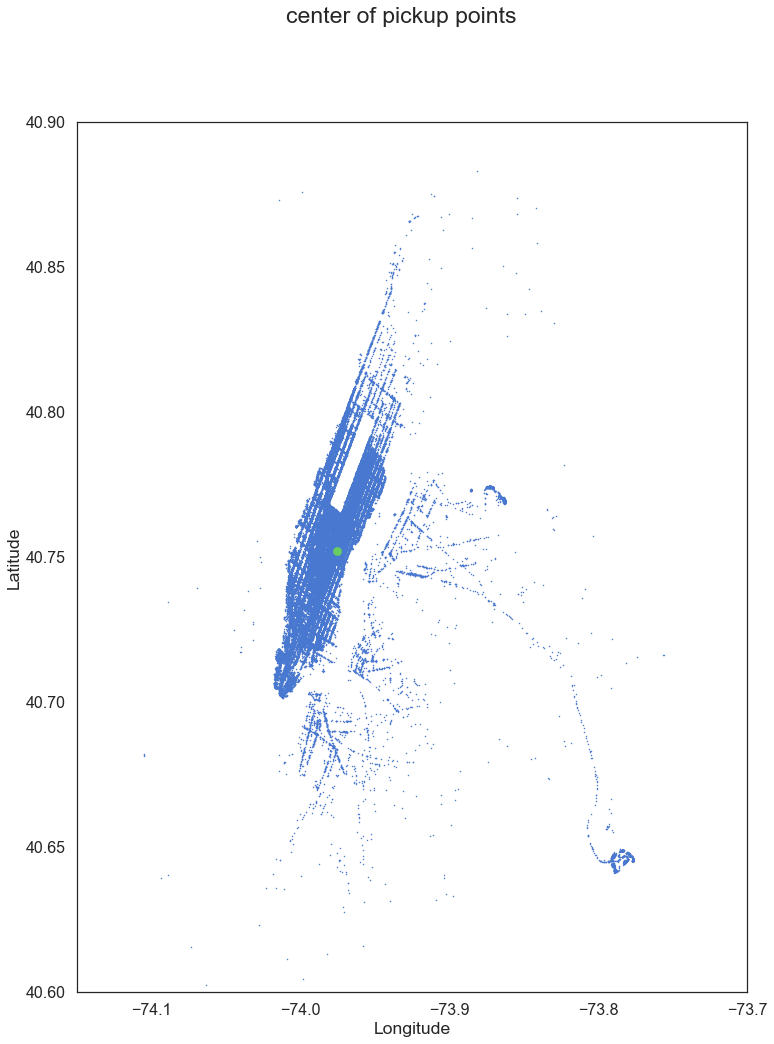

In [26]:
#calculate centroid of all pickup points, if pickup is closer to centroid then traffic in this area is bigger
centroid = (sum(train["pickup_longitude"]) / len(train), sum(train["pickup_latitude"]) / len(train))
fig, ax = plt.subplots(nrows=1,ncols=1)
df_scatter = ax.scatter(train['pickup_longitude'].values[:100000], \
                        train['pickup_latitude'].values[:100000], s=1)
center_scatter = ax.scatter(centroid[0], \
                            centroid[1],\
                            s=70)
plt.suptitle('center of pickup points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(lg_border)
ax.set_ylim(lt_border)
plt.savefig('../Wyniki/Wykresy/centroid.png')
plt.show()

#calculate distance from centroid as the crow flies
train.loc[:,"pickup_distance_straight_from_center"] = np.sqrt((train["pickup_longitude"] - centroid[0])**2 +\
                                          (train["pickup_latitude"] - centroid[1])**2 )
test.loc[:,"pickup_distance_straight_from_center"] = np.sqrt((test["pickup_longitude"] - centroid[0])**2 +\
                                          (test["pickup_latitude"] - centroid[1])**2 )
#etter results with stright distance than with harvesine
#train.loc[:, 'pickup_distance_haversine_from_center'] = haversine(train['pickup_latitude'].values, train['pickup_longitude'].values, centroid[1], centroid[0])
#test.loc[:, 'pickup_distance_haversine_from_center'] = haversine(test['pickup_latitude'].values, test['pickup_longitude'].values, centroid[1], centroid[0])

Number of clusters: 26


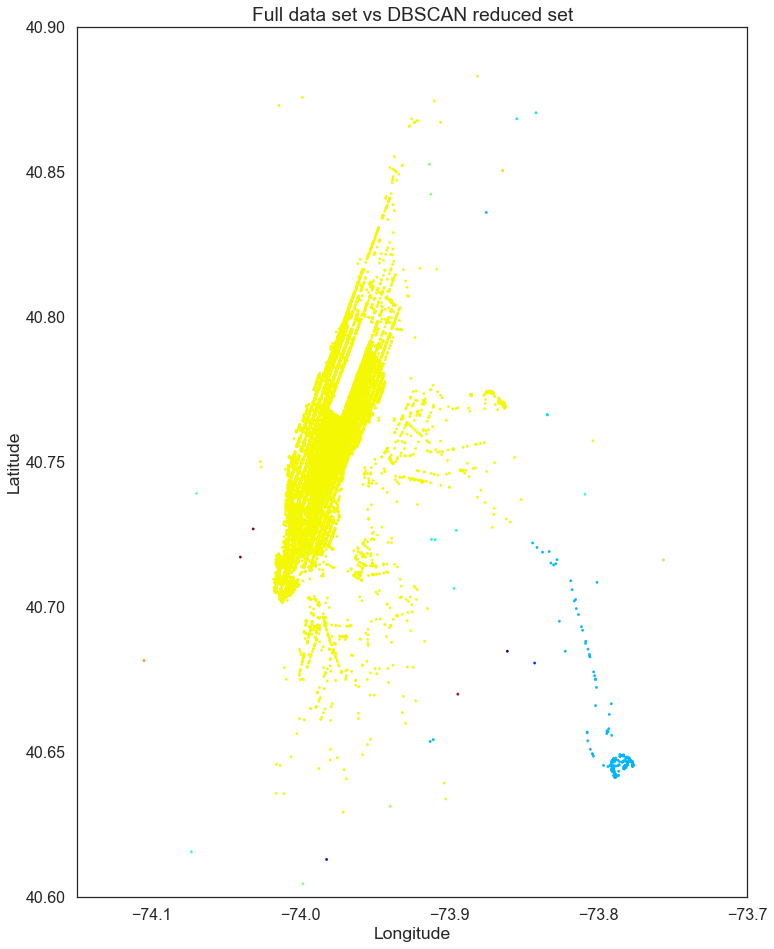

In [27]:
#http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
#przeprowadzic klasteryzację dbsacanem lub kmeans
#dbscan clasterization
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
coords = train.as_matrix(columns=['pickup_latitude', 'pickup_longitude'])
number_of_consider_coords = 30000
coords = coords[:number_of_consider_coords,:]
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

#lg_border = (-74.15, -73.7)
#lt_border = (40.6, 40.9)

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

fig, ax = plt.subplots(nrows=1,ncols=1)
df_scatter = ax.scatter(train['pickup_longitude'].values[:number_of_consider_coords], \
                        train['pickup_latitude'].values[:number_of_consider_coords], \
                        c=coords[cluster_labels,0], \
                        cmap=cmap, \
                        s=5, \
                        label='train')
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(lg_border)
ax.set_ylim(lt_border)
plt.savefig('../Wyniki/Wykresy/dbscan.png')
plt.show()
#too high computational complexity, with 100 000 coords gets over 8 gb of ram easily
#try kmeans

In [28]:
#kmeans cluzsterization
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
number_of_consider_coords = 200000
#get random starting points
random_rows = np.random.permutation(len(coords))[:number_of_consider_coords]
#kmeans run, 50 clusters is the best
kmeans = MiniBatchKMeans(n_clusters=65, batch_size=25000).fit(coords[random_rows])
#add cluster number to train and test data
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

fig, ax = plt.subplots(nrows=1,ncols=1)
ax.scatter(train.pickup_longitude.values[:number_of_consider_coords], \
           train.pickup_latitude.values[:number_of_consider_coords],\
           s=5,\
           c=train.pickup_cluster[:number_of_consider_coords].values,\
           cmap=cmap)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_xlim(lg_border)
ax.set_ylim(lt_border)
plt.savefig('../Wyniki/Wykresy/kmeans.png')
plt.show()

In [29]:
#get fastest routes from OSRM ([Open Source Routing Machine]
first_part = pd.read_csv('../Dane/fast_train_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
second_part = pd.read_csv('../Dane/fast_train_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_route_external = pd.read_csv('../Dane/fast_test.csv', \
                                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_route_external = pd.concat((first_part, second_part))
train = train.merge(train_route_external, how='left', on='id')
test = test.merge(test_route_external, how='left', on='id')

In [30]:
attributes = list(train.columns)
#print different attributes in train and test sets
print(np.setdiff1d(train.columns, test.columns))
#exclude attributes: which occur only in train set, pickup_datetime and pickup_date because we get divide it to hour, day,
#week month, id because it's usless in meaning of training,
excluded_attributes = ['id', \
                        'log_of_duration', \
                        'pickup_datetime', \
                        'dropoff_datetime', \
                        'trip_duration',\
                        'pickup_date', \
                        'avg_speed']
#left only valid attributes
attributes = [f for f in train.columns if f not in excluded_attributes]
print('%i features' % len(attributes))
train[attributes].count()
y = np.log(train['trip_duration'].values + 1)

['avg_speed' 'dropoff_datetime' 'log_of_duration' 'trip_duration']
20 features


In [31]:
#set xgboost
Xtr, Xv, ytr, yv = train_test_split(train[attributes].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[attributes].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.2, 'colsample_bytree': 0.3, 'max_depth': 14,
            'subsample': 0.8, 'lambda': 1., 'n_jobs': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(attributes))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': attributes})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)
#show features importance
feature_importance[['feature_name', 'importance']].sort_values(by='importance', ascending=False)

[0]	train-rmse:4.77528	valid-rmse:4.77487
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.637101	valid-rmse:0.642634
[20]	train-rmse:0.332967	valid-rmse:0.352587
[30]	train-rmse:0.308742	valid-rmse:0.337125
[40]	train-rmse:0.297002	valid-rmse:0.332258
[50]	train-rmse:0.287657	valid-rmse:0.328936
[59]	train-rmse:0.283964	valid-rmse:0.328423


feature_name  importance
1                       dropoff_latitude       17218
2                      dropoff_longitude       11903
15                              distance       11255
10                       pickup_latitude       11172
8                              direction       10710
11                      pickup_longitude        9813
14                       dropoff_cluster        8250
5   pickup_distance_straight_from_center        7922
7                         pickup_cluster        7614
13                          day_of_month        7181
0                      total_travel_time        6812
6                         total_distance        5894
3                                   week        5755
18                                  hour        4339
9                        number_of_steps        3549
16                                 month        3271
4                                    day        1436
17                       passenger_count        1334
12                             vendor_id        1023
19                    store_and_fwd_flag           9

In [32]:
ypred = model.predict(dvalid)
ytest = model.predict(dtest)
test['trip_duration'] = np.exp(ytest) - 1
#save test set with prediction duration to subbmision
test[['id', 'trip_duration']].to_csv('submission.csv', index=False)

#"We expect the solution file to have 625134 prediction rows"
if test.shape[0] == 625134:
    print("Submission rows number OK")


Submission rows number OK
